# Table of Contents

- [Preparation](#preparation)
    - [Import Library](#import_library)
    - [Import Data](#import_data)
- [Exploratory Data Analysis and Data Cleaning](#eda_and_clean)
    - [Columns Name](#col_name)
    - [Columns Data Type](#col_data_type)
        - [Kilometres Column](#kilometres_col_dtype)
        - [Doors Column](#doors_col_dtype)
        - [City Column](#city_col_dtype)
        - [Highway Column](#highway_col_dtype)
    - [Turn Other/Donât Know into NaN Values](#other_to_nan)
    - [Check Missing Values](#missing_values)
    - [Data Distribution](#data_distribution)
        - [Categorical Data](#cat_distribution)
            - [Correcting Drivetrain](#correcting_drivetrain)
            - [Correcting FuelType](#correcting_fuel_type)
        - [Numerical Data](#num_distribution)
            - [Drop Invalid Year](#invalid_year)


# Preparation <a name='preparation'></a>

## Import Library <a name='import_library'></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from zipfile import ZipFile

## Import Data <a name='import_data'></a>

In [2]:
with ZipFile('used-vehicles-for-sale.zip') as raw_zip:
    raw_zip.extractall(path='datasets')
    
    file_name = raw_zip.namelist()
    
    raw_data = []
    
    for file in file_name:
        try:
            raw_data.append(pd.read_csv(f'datasets/{file}'))
        except UnicodeDecodeError:
            print(f'{file}: Wrong format file')
        
    print(file_name)

formattedData.xlsx: Wrong format file
['formattedData.xlsx', 'originalData.csv']


In [3]:
raw_data[0].head()

,Unnamed: 0,Year,Make,Model,Kilometres,Body Type,Engine,Transmission,Drivetrain,Exterior Colour,Interior Colour,Passengers,Doors,Fuel Type,City,Highway,Price
0,0,2019,Acura,MDX,53052 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Majestic Black Pearl,Red,NaN,NaN,Gas,12.2L/100km,9.0L - 9.5L/100km,43880
1,1,2018,Acura,MDX,77127 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Modern Steel Metallic,Black,NaN,NaN,Gas,12.6L/100km,9.0L/100km,36486
2,2,2019,Acura,RDX,33032 km,SUV,2.0L 4cyl,10 Speed Automatic,AWD,White Diamond Pearl,Black,5.0,4,Premium Unleaded,11.0L/100km,8.6L/100km,40888
3,3,2020,Acura,RDX,50702 km,SUV,4 Cylinder Engine,NaN,AWD,Platinum White Pearl,Black,NaN,NaN,Gas,11.0L/100km,8.6L/100km,44599
4,4,2021,Acura,RDX,67950 km,SUV,4 Cylinder Engine,NaN,AWD,Apex Blue Pearl,Red,NaN,NaN,Gas,11.3L/100km,9.1L/100km,46989


In [4]:
full_data = raw_data[0].iloc[:, 1:]

full_data.head()

,Year,Make,Model,Kilometres,Body Type,Engine,Transmission,Drivetrain,Exterior Colour,Interior Colour,Passengers,Doors,Fuel Type,City,Highway,Price
0,2019,Acura,MDX,53052 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Majestic Black Pearl,Red,NaN,NaN,Gas,12.2L/100km,9.0L - 9.5L/100km,43880
1,2018,Acura,MDX,77127 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Modern Steel Metallic,Black,NaN,NaN,Gas,12.6L/100km,9.0L/100km,36486
2,2019,Acura,RDX,33032 km,SUV,2.0L 4cyl,10 Speed Automatic,AWD,White Diamond Pearl,Black,5.0,4,Premium Unleaded,11.0L/100km,8.6L/100km,40888
3,2020,Acura,RDX,50702 km,SUV,4 Cylinder Engine,NaN,AWD,Platinum White Pearl,Black,NaN,NaN,Gas,11.0L/100km,8.6L/100km,44599
4,2021,Acura,RDX,67950 km,SUV,4 Cylinder Engine,NaN,AWD,Apex Blue Pearl,Red,NaN,NaN,Gas,11.3L/100km,9.1L/100km,46989


# Exploratory Data Analysis and Data Cleaning <a name='eda_and_clean'></a>

## Columns Name <a name='col_name'></a>

In [5]:
full_data.columns

Index(['Year', 'Make', 'Model', 'Kilometres', 'Body Type', ' Engine',
       ' Transmission', ' Drivetrain', ' Exterior Colour', ' Interior Colour',
       ' Passengers', ' Doors', ' Fuel Type', ' City', ' Highway', 'Price'],
      dtype='object')

*Warning: Some of column name contains space in the beginning. Hence we will remove it*

In [6]:
full_data.columns = full_data.columns.str.replace(' ', '')

full_data.columns

Index(['Year', 'Make', 'Model', 'Kilometres', 'BodyType', 'Engine',
       'Transmission', 'Drivetrain', 'ExteriorColour', 'InteriorColour',
       'Passengers', 'Doors', 'FuelType', 'City', 'Highway', 'Price'],
      dtype='object')

Columns Information
1. `Year`: The year of the vehicle (year release)
2. `Make`: The make of the vehicle (brand)
3. `Model`: The model of the vehicle
4. `Kilometres`: The distance the vehicle has travelled in Kilometeres
5. `BodyType`: The type of Body the vehicle has
6. `Engine`: Type of Engine in the vehicle
7. `Transmission`: Transmission used in the vehicle
8. `Drivertrain`: Drivetrain configuration of the vehicle
9. `ExteriorColour`: Exterior Colour of the vehicle
10. `InteriorColour`: Interior Colour of the vehicle.
11. `Passengers`: Passengers capacity
12. `Doors`: The number of doors
13. `Fuel Type`: Fuel type of the vehicle
14. `City`: Fuel used per 100 km in city
15. `Highway`: Fuel used per 100 km in highway
16. `Price`: Price of the vehicle in 2023

## Columns Data Type <a name='col_data_type'></a>

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24198 entries, 0 to 24197
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            24198 non-null  int64  
 1   Make            24198 non-null  object 
 2   Model           24198 non-null  object 
 3   Kilometres      23965 non-null  object 
 4   BodyType        22968 non-null  object 
 5   Engine          22136 non-null  object 
 6   Transmission    22854 non-null  object 
 7   Drivetrain      22967 non-null  object 
 8   ExteriorColour  23182 non-null  object 
 9   InteriorColour  16418 non-null  object 
 10  Passengers      12025 non-null  float64
 11  Doors           19611 non-null  object 
 12  FuelType        23464 non-null  object 
 13  City            17835 non-null  object 
 14  Highway         17835 non-null  object 
 15  Price           24198 non-null  int64  
dtypes: float64(1), int64(2), object(13)
memory usage: 3.0+ MB


Based on the columns information, `Kilometres`, `Doors`, `City`, and `Highway` should be a numeric data type. Let's inspect it one by one.

### Kilometres Column <a name='kilometres_column_dtype'></a>

In [8]:
full_data['Kilometres']

0        53052 km
1        77127 km
2        33032 km
3        50702 km
4        67950 km
           ...   
24193    81000 km
24194    92450 km
24195    92000 km
24196    67000 km
24197    43245 km
Name: Kilometres, Length: 24198, dtype: object

The problem is the data contains string 'km', hence pandas treat it as object data type. Let's check if all rows contains 'km'.

In [9]:
full_data['Kilometres'].str.contains('km').value_counts()

True    23965
Name: Kilometres, dtype: int64

All rows contains 'km', so we will remove it and then convert the column data type into float.

In [10]:
full_data['Kilometres'] = full_data['Kilometres'].str.replace(' km', '').astype(float)

### Doors Column <a name='doors_column_dtype'></a>

In [11]:
full_data['Doors']

0            NaN
1            NaN
2              4
3            NaN
4            NaN
          ...   
24193    5 doors
24194          5
24195    4 doors
24196    4 doors
24197    5 doors
Name: Doors, Length: 24198, dtype: object

In [12]:
full_data['Doors'].value_counts()

4                     14313
2                      2907
4 doors                1004
5                       675
5 doors                 361
2 doors                 219
3                        89
3 doors                  39
Other/Donât Know        3
2.0                       1
Name: Doors, dtype: int64

Same as previous column, the problem is there some rows contains string.

In [13]:
full_data['Doors'] = pd.to_numeric(
    full_data['Doors'].str.replace(' doors', ''),
    errors='coerce'
).astype('Int64')

We use `pd.to_numeric` instead of `astype` like the previous one, it's because `pd.to_numeric` can handle invalid input i.e. `Other/Donât Know` and turn them into `NaN` value, after that we use `astype` to convert the data type into `Int64` because it can handle nullable int data.

**Note: Since there are some rows that contains `Other/Donât Know`, we should check other columns, if they contains it or not, and then turn them into `NaN` values.**

### City Column <a name='city_column_dtype'></a>

In [14]:
full_data['City']

0        12.2L/100km
1        12.6L/100km
2        11.0L/100km
3        11.0L/100km
4        11.3L/100km
            ...     
24193            NaN
24194            NaN
24195            NaN
24196            NaN
24197            NaN
Name: City, Length: 24198, dtype: object

In [15]:
full_data['City'].str.contains('100km').value_counts()

True    17835
Name: City, dtype: int64

It all contains '100km', just in case if some rows contains space, let's remove the space to make sure we can remove 'L/100km'.

In [16]:
city_no_str = full_data['City'].str.replace(' ', '').str.replace('L/100km', '')

city_no_str

0        12.2
1        12.6
2        11.0
3        11.0
4        11.3
         ... 
24193     NaN
24194     NaN
24195     NaN
24196     NaN
24197     NaN
Name: City, Length: 24198, dtype: object

In [17]:
city_no_str.value_counts()

10.8          482
9.8           478
11.5          466
7.8           420
11.0          374
             ... 
4.8             1
6.4L-6.9        1
6.6L-7.1        1
12.6L-13.1      1
8.9L-9.0        1
Name: City, Length: 523, dtype: int64

It turns out some rows contains '-', let's take the last number and ditch the first number. Here is the implementation:
1. We split the string based on '-' and expand it to dataframe, so there will be 2 columns, we store it in variable called `city_split`
2. The rows that doesn't contains '-', their column 1 would be null, hence we use it as `city_mask`
3. We filter the splitted data and shift the data in column 0 to column 1
4. Finally we only take the column 1 and convert it to float

In [18]:
# step 1
city_split = city_no_str.str.split('-', expand=True)

# step 2
city_mask = city_split[1].isnull()

# step 3
city_split[city_mask] = city_split[city_mask].shift(axis=1)

# step 4
full_data['City'] = city_split[1].astype(float)

### Highway Column <a name='highway_column_dtype'></a>

Since this columns similar to `City` column, we will perform the same steps.

In [19]:
full_data['Highway']

0        9.0L - 9.5L/100km
1               9.0L/100km
2               8.6L/100km
3               8.6L/100km
4               9.1L/100km
               ...        
24193                  NaN
24194                  NaN
24195                  NaN
24196                  NaN
24197                  NaN
Name: Highway, Length: 24198, dtype: object

In [20]:
highway_no_str = full_data['Highway'].str.replace(' ', '').str.replace('L/100km', '')

# step 1
highway_split = highway_no_str.str.split('-', expand=True)

# step 2
highway_mask = highway_split[1].isnull()

# step 3
highway_split[highway_mask] = highway_split[highway_mask].shift(axis=1)

# step 4
full_data['Highway'] = highway_split[1].astype(float)

All done! Let's check the data type again

In [21]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24198 entries, 0 to 24197
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            24198 non-null  int64  
 1   Make            24198 non-null  object 
 2   Model           24198 non-null  object 
 3   Kilometres      23965 non-null  float64
 4   BodyType        22968 non-null  object 
 5   Engine          22136 non-null  object 
 6   Transmission    22854 non-null  object 
 7   Drivetrain      22967 non-null  object 
 8   ExteriorColour  23182 non-null  object 
 9   InteriorColour  16418 non-null  object 
 10  Passengers      12025 non-null  float64
 11  Doors           19608 non-null  Int64  
 12  FuelType        23464 non-null  object 
 13  City            17835 non-null  float64
 14  Highway         17835 non-null  float64
 15  Price           24198 non-null  int64  
dtypes: Int64(1), float64(4), int64(2), object(9)
memory usage: 3.0+ MB


## Turn `Other/Donât Know` into `NaN` Values <a name='other_to_nan'></a>

We will inspect the columns with type of `object`.

In [22]:
for column in full_data.select_dtypes(include='object').columns:
    temp_other_sum = full_data.select_dtypes(include='object')[column].str.contains('other', case=False).sum()
    
    print(f'{column} contains {temp_other_sum} "other" values')

Make contains 0 "other" values
Model contains 0 "other" values
BodyType contains 0 "other" values
Engine contains 0 "other" values
Transmission contains 0 "other" values
Drivetrain contains 0 "other" values
ExteriorColour contains 0 "other" values
InteriorColour contains 0 "other" values
FuelType contains 126 "other" values


Let's turn rows from `FuelType` that contains `Other/Donât Know` into `NaN` values.

In [23]:
mask_fuel_type = full_data['FuelType'].str.contains('other', case=False, na=False)

full_data['FuelType'][mask_fuel_type] = None

/tmp/ipykernel_18940/3247055738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['FuelType'][mask_fuel_type] = None


## Check Missing Values <a name='missing_values'></a>

In [24]:
print(f'''
Missing values ratio for each columns:

{(full_data.isnull().sum()/len(full_data)).sort_values(ascending=False) }''')


Missing values ratio for each columns:

Passengers        0.503058
InteriorColour    0.321514
City              0.262956
Highway           0.262956
Doors             0.189685
Engine            0.085214
Transmission      0.055542
Drivetrain        0.050872
BodyType          0.050831
ExteriorColour    0.041987
FuelType          0.035540
Kilometres        0.009629
Year              0.000000
Make              0.000000
Model             0.000000
Price             0.000000
dtype: float64


About half rows in `Passengers` column is missing.

## Data Distribution <a name='data_distribution'></a>

### Categorical Data <a name='cat_distribution'></a>

In [25]:
full_cat_data = full_data.select_dtypes(include='object')

full_cat_data.head()

,Make,Model,BodyType,Engine,Transmission,Drivetrain,ExteriorColour,InteriorColour,FuelType
0,Acura,MDX,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Majestic Black Pearl,Red,Gas
1,Acura,MDX,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Modern Steel Metallic,Black,Gas
2,Acura,RDX,SUV,2.0L 4cyl,10 Speed Automatic,AWD,White Diamond Pearl,Black,Premium Unleaded
3,Acura,RDX,SUV,4 Cylinder Engine,NaN,AWD,Platinum White Pearl,Black,Gas
4,Acura,RDX,SUV,4 Cylinder Engine,NaN,AWD,Apex Blue Pearl,Red,Gas


Before we visualize the data distribution, let's check the unique values for each columns and we only visualize the columns with certain number of unique values.

In [26]:
full_cat_data.nunique()

Make                51
Model              673
BodyType            30
Engine            1210
Transmission        22
Drivetrain           7
ExteriorColour    1457
InteriorColour      16
FuelType            13
dtype: int64

Let's visualize these columns: `Make`, `BodyType`, `Transmission`, `Drivetrain`, `InteriorColour`, and `FuelType`

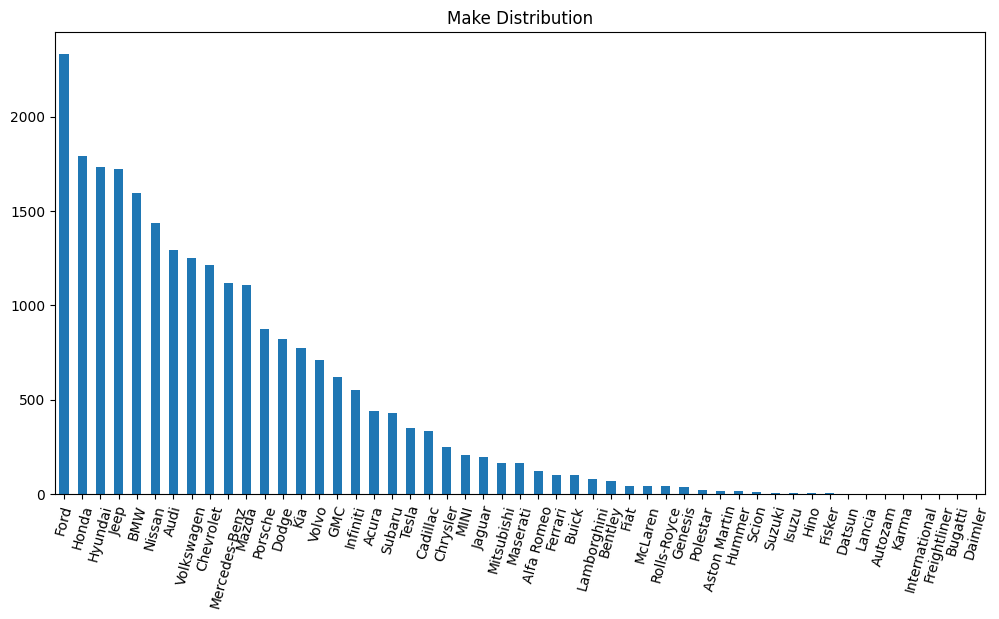

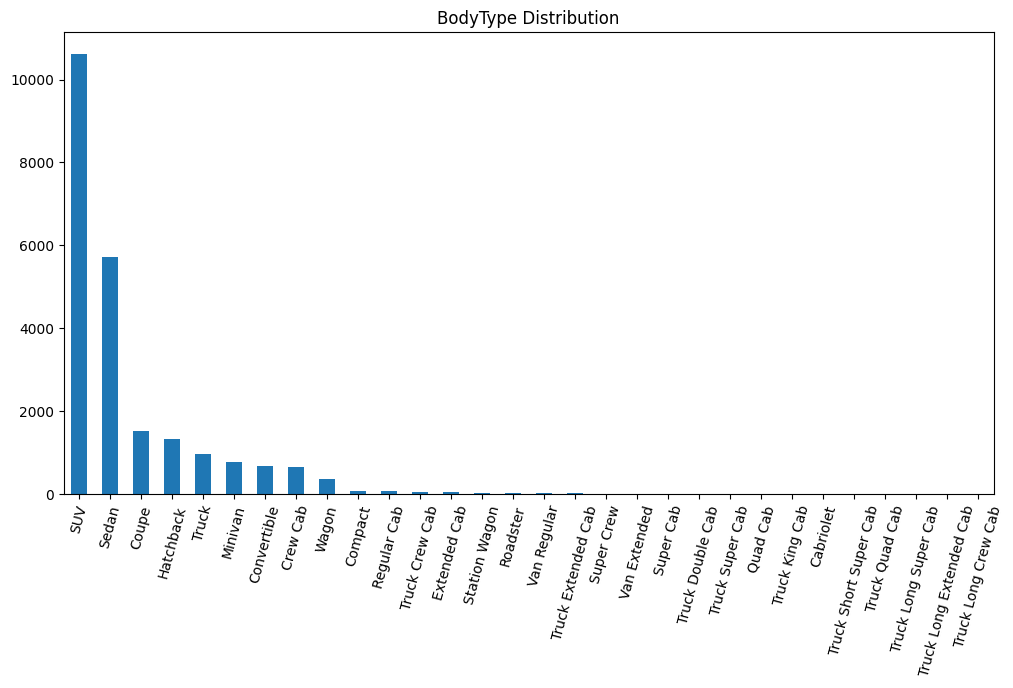

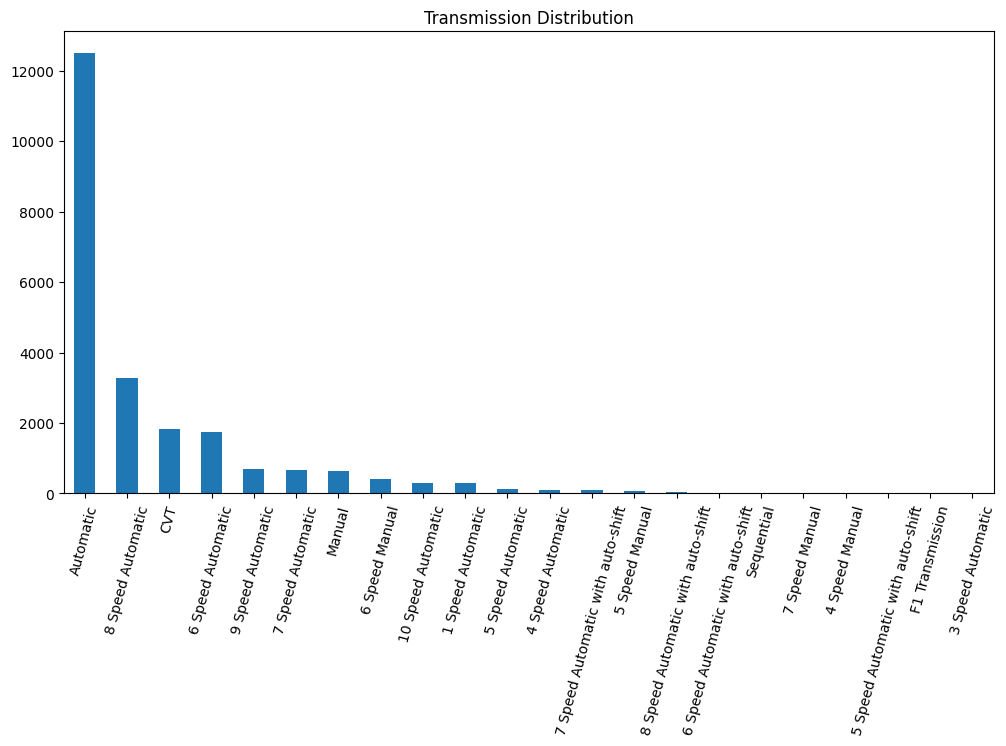

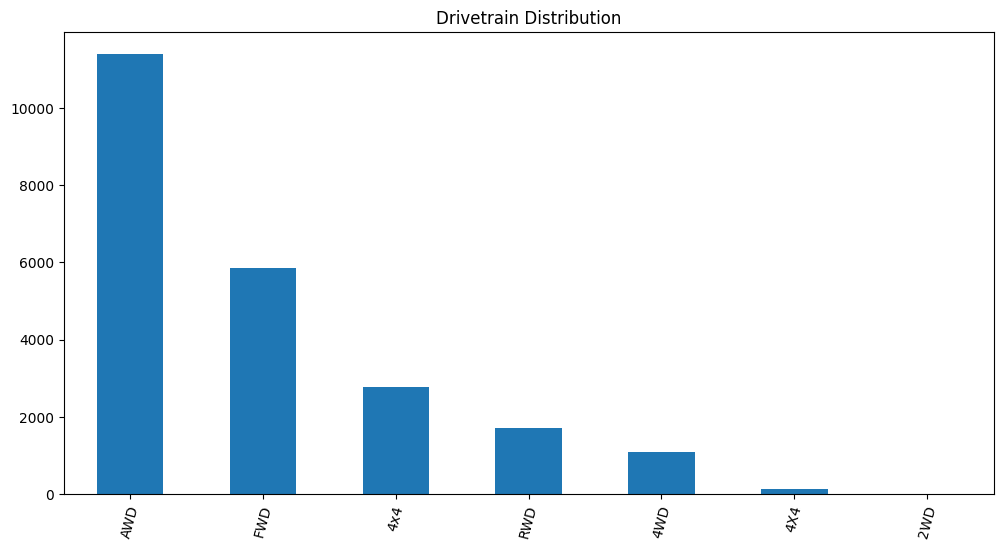

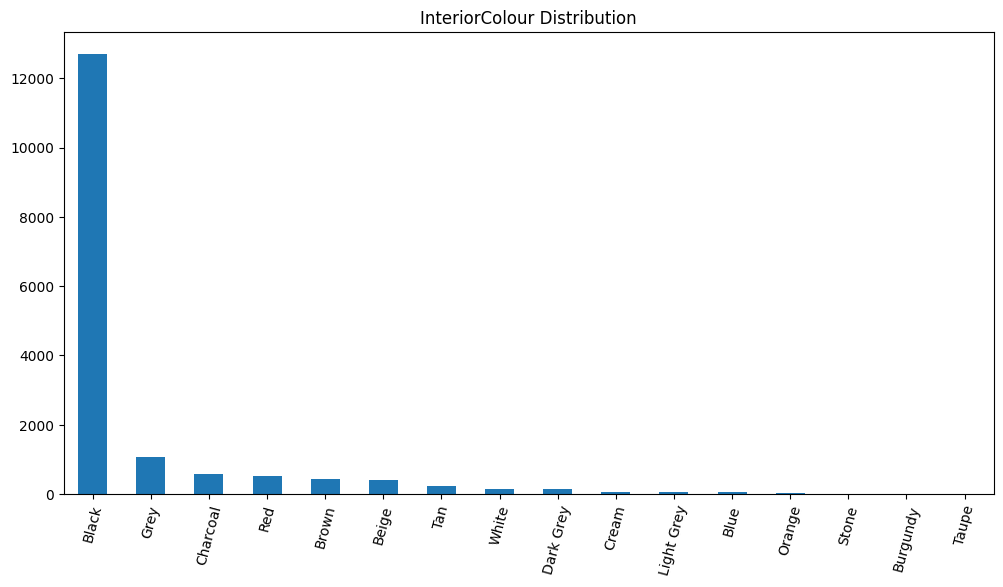

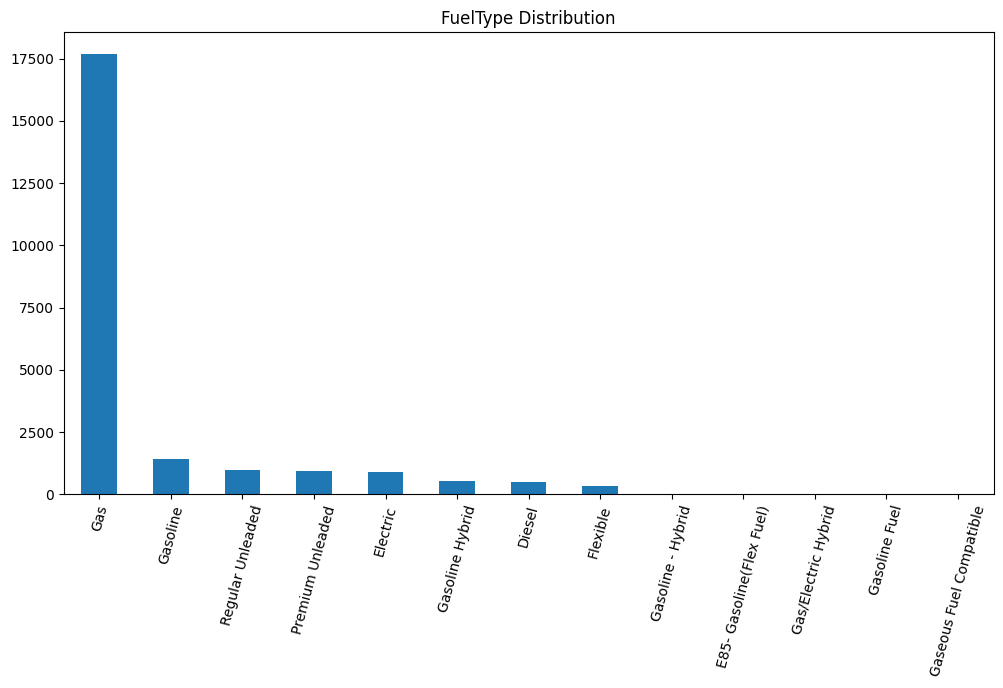

In [27]:
for column in ['Make', 'BodyType', 'Transmission', 'Drivetrain', 'InteriorColour', 'FuelType']:
    full_cat_data[column].value_counts().plot(
        kind='bar',
        title=f'{column} Distribution',
        rot=75,
        figsize=(12, 6)
    )
    plt.show()

Some of values from `Drivetrain` and `FuelType` column have same term but different name e.g. in column `FuelType` the value 'Gas', 'Gasoline', 'Gasoline Fuel', and 'Gaseous Fuel Compatible' have same term, which is 'Gasoline'.

#### Correcting Drivetrain <a name='correcting_drivetrain'></a>

In [28]:
full_cat_data['Drivetrain'].unique()

array(['AWD', 'FWD', nan, '4X4', 'RWD', '4x4', '4WD', '2WD'], dtype=object)

The values '4X4', '4x4', and '4WD' have a same term, which is '4WD'. While '2WD' can be either 'FWD' or 'RWD', so we can't decide it what is the true for it, hence we will convert it to null values. We will map those invalid values to valid values.

In [29]:
drivetrain_map = {
    'AWD': 'AWD',
    'FWD': 'FWD',
    'RWD': 'RWD',
    '4WD': '4WD',
    '4X4': '4WD',
    '4x4': '4WD',
    '2WD': None
}

full_cat_data['Drivetrain'] = full_cat_data['Drivetrain'].map(drivetrain_map)

#### Correcting FuelType <a name='correcting_fuel_type'></a>

In [30]:
full_cat_data['FuelType'].value_counts()

Gas                         17670
Gasoline                     1409
Regular Unleaded              970
Premium Unleaded              921
Electric                      886
Gasoline Hybrid               549
Diesel                        510
Flexible                      350
Gasoline - Hybrid              27
E85- Gasoline(Flex Fuel)       19
Gas/Electric Hybrid            13
Gasoline Fuel                  13
Gaseous Fuel Compatible         1
Name: FuelType, dtype: int64

For `FuelType` column let's we rewrite it in mathematical terms, we write a function that mapping those input into valid input:

$ f(x):raw\_input \rightarrow valid\_input $

Where $raw\_input$ is the unique values from `FuelType` column, while $valid\_input = \{'Gasoline',\;'Hybrid',\;'Flexible',\;'Diesel',\;'Electric',\;'Regular Unleaded',\;'Premium Unleaded'\}$

$ f(x)=   \left\{
\begin{array}{ll}
      'Gasoline' & x \in \{'Gas',\;'Gasoline',\;'Gasoline\;Fuel',\;'Gaseous\;Fuel\;Compatible'\} \\
      'Hybrid' & x \in \{'Gasoline\;Hybrid',\;'Gas/Electric\;Hybrid'\} \\
      'Flexible' & x \in \{'Flexible',\;'E85-\;Gasoline(Flex\;Fuel)'\} \\
      'Diesel' & x \in \{'Diesel'\} \\
      'Electric' & x \in \{'Electric'\} \\
      'Regular\;Unleaded' & x \in \{'Regular\;Unleaded'\} \\
      'Premium\;Unleaded' & x \in \{'Premium\;Unleaded'\} \\
      None & Otherwise
\end{array} 
\right.  $

Let's implement it in the code.

In [31]:
domain_gas = ['Gas', 'Gasoline', 'Gasoline Fuel', 'Gaseous Fuel Compatible']
domain_hybrid = ['Gasoline Hybrid', 'Gas/Electric Hybrid']
domain_flexible = ['Flexible', 'E85- Gasoline(Flex Fuel)']

gas_map = dict.fromkeys(domain_gas, 'Gasoline')
hybrid_map = dict.fromkeys(domain_hybrid, 'Hybrid')
flexible_map = dict.fromkeys(domain_flexible, 'Flexible')

fuel_type_map = {
    **gas_map,
    **hybrid_map,
    **flexible_map,
    'Diesel': 'Diesel',
    'Electric': 'Electric',
    'Regular Unleaded': 'Regular Unleaded',
    'Premium Unleaded': 'Premium Unleaded'
}

full_cat_data['FuelType'] = full_cat_data['FuelType'].map(fuel_type_map)

### Numerical Data <a name='num_distribution'></a>

In [32]:
full_num_data = full_data.select_dtypes(exclude='object')

full_num_data.describe()

,Year,Kilometres,Passengers,Doors,City,Highway,Price
count,24198.000000,2.396500e+04,12025.000000,19608.0,17835.000000,17835.000000,2.419800e+04
mean,2018.263534,6.960898e+04,5.097963,3.727356,11.319159,8.482478,5.007124e+04
std,5.155973,7.325661e+04,1.009955,0.78928,2.618162,1.875762,7.462272e+04
min,1928.000000,0.000000e+00,2.000000,2.0,2.300000,2.600000,5.000000e+02
25%,2016.000000,7.701000e+03,5.000000,4.0,9.400000,7.200000,2.368500e+04
50%,2019.000000,5.422300e+04,5.000000,4.0,11.100000,8.400000,3.699000e+04
75%,2022.000000,1.080000e+05,5.000000,4.0,12.900000,9.600000,5.998000e+04
max,2024.000000,2.470000e+06,15.000000,5.0,39.200000,42.800000,3.999998e+06


Hold on, the maximum value of `Year` column is 2024, which is exceed current year (2023), we will drop those rows.

#### Drop Invalid `Year` <a name='invalid_year'></a>

In [51]:
mask_year = full_num_data['Year'] > 2023

full_num_data = full_num_data.drop(full_num_data['Year'][mask_year].index).reset_index(drop=True)
full_cat_data = full_cat_data.drop(full_num_data['Year'][mask_year].index).reset_index(drop=True)

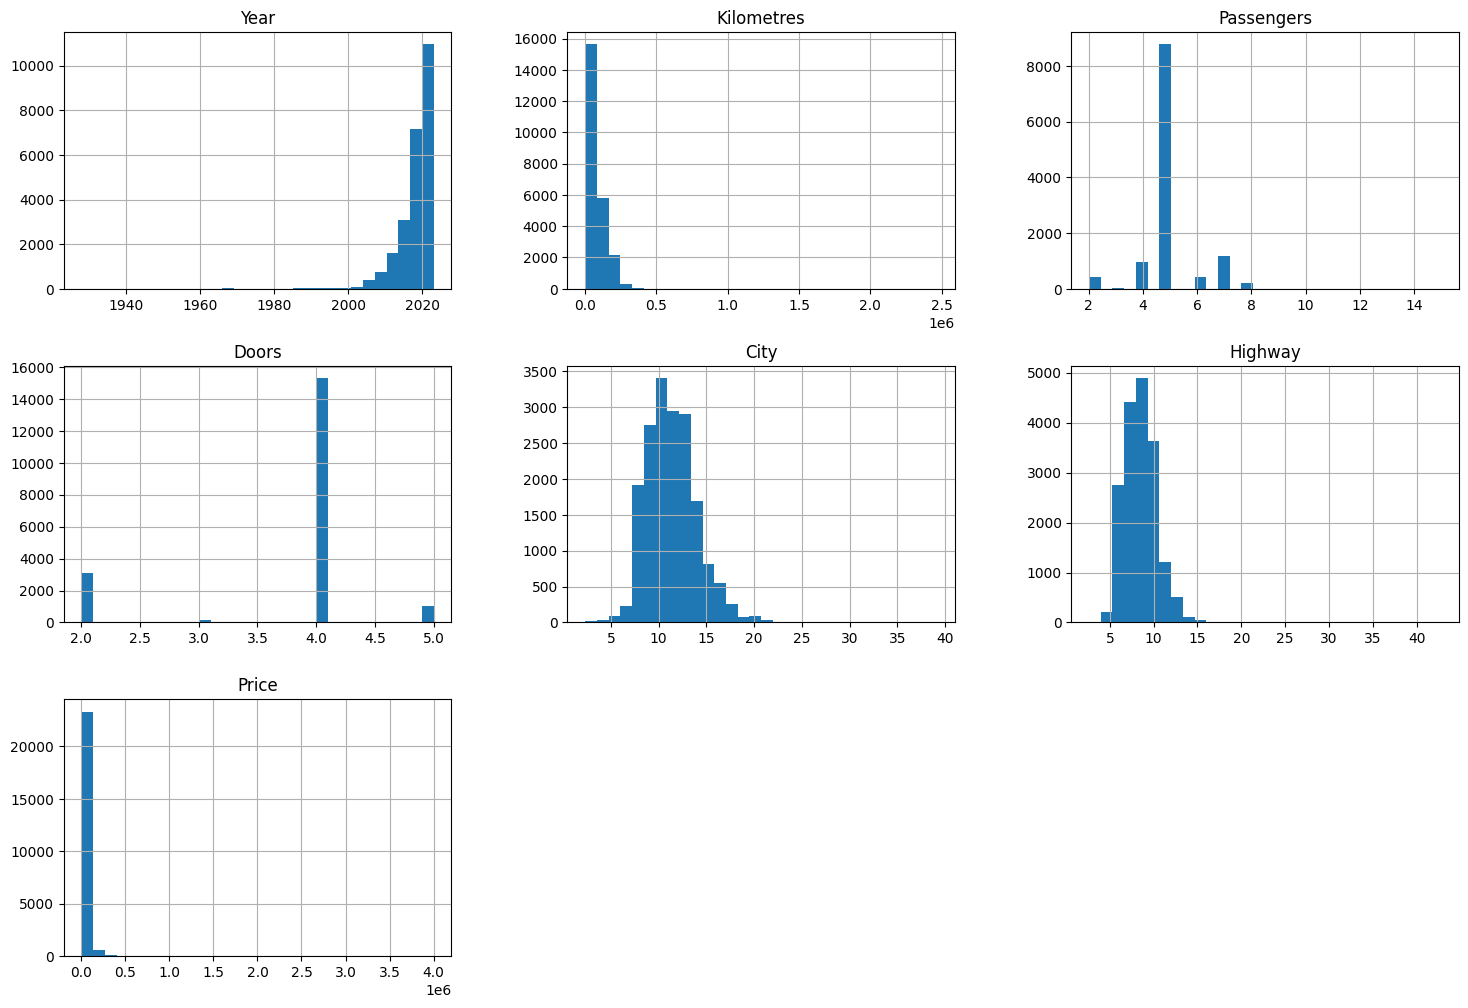

In [52]:
full_num_data.hist(
    bins=30,
    figsize=(18, 12)
)

plt.show()